# Z500_WT_correlation.ipynb

#!/usr/bin/env python

    File name: Z500_WT_correlation.ipynb
    Author: Andreas Prein
    E-mail: prein@ucar.edu
    Date created: 26.01.2021
    Date last modified: 26.01.2021

    ############################################################## 
    Purpos:
    Calculates Z500 annomalies for each WT
    
    This requires to first run:
    ~/projects/Arizona_WTing/programs/WTing/Centroids-and-Scatterplot.py

    1) read in the WT arrays for focus basis

    2) read in daily mean ERA5 500 hPa ZG values

    3) calculate correlation coefficients between the ZG500 time series and the WT time seris in June,July


In [1]:
from dateutil import rrule
import datetime
import glob
from netCDF4 import Dataset
import sys, traceback
import dateutil.parser as dparser
import string
from pdb import set_trace as stop
import numpy as np
import numpy.ma as ma
import os
# from mpl_toolkits import basemap
import pickle
import subprocess
import pandas as pd
from scipy import stats
import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import pylab as plt
import random
import scipy.ndimage as ndimage
import scipy
import shapefile
import matplotlib.path as mplPath
from matplotlib.patches import Polygon as Polygon2
# Cluster specific modules
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy.cluster.vq import kmeans2,vq, whiten
from scipy.ndimage import gaussian_filter
import seaborn as sns
# import metpy.calc as mpcalc
import shapefile as shp
import sys
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile
from scipy import signal
from numpy.linalg import lstsq
import random

def read_shapefile(sf):
    """
    Read a shapefile into a Pandas dataframe with a 'coords' 
    column holding the geometry information. This uses the pyshp
    package
    """
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    shps = [s.points for s in sf.shapes()]
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    return df

#### speed up interpolation
import scipy.interpolate as spint
import scipy.spatial.qhull as qhull
import numpy as np
import h5py
import xarray as xr

def interp_weights(xy, uv,d=2):
    tri = qhull.Delaunay(xy)
    simplex = tri.find_simplex(uv)
    vertices = np.take(tri.simplices, simplex, axis=0)
    temp = np.take(tri.transform, simplex, axis=0)
    delta = uv - temp[:, d]
    bary = np.einsum('njk,nk->nj', temp[:, :d, :], delta)
    return vertices, np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))

def interpolate(values, vtx, wts):
    return np.einsum('nj,nj->n', np.take(values, vtx), wts)

### Setup

In [2]:
sDataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/'
HUC2 = ['1501','1502', '1503', '1504','1505', '1506', '1507', '1810','HUC6-00','HUC6-01','HUC6-02','HUC6-03','HUC6-04','HUC6-05']
DW_Regions=[['1501', '1503', '1507', '1810'], ['1502', '1504','1505', '1506'],['HUC6-00','HUC6-01','HUC6-02','HUC6-05'],['HUC6-03','HUC6-04']]
REGIONS = ['AZ_West','AZ_East','NM_North','NM_South']
sMonths='6-7-8-9-10'
Season = 'JJASO'
YYYY_stamp='1982-2018'
iNrOfExtremes = 13514
iMonths=[6,7,8,9,10]

VarComp = [['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850'],
    ['Q850']]

### Load the Eucledian Distances and the Daily Precipitation for each Region

In [3]:
for re in range(len(HUC2)):
    sRegion=HUC2[re]
    ss='-'
    VarsJoint=ss.join(VarComp[re])
    sClusterSave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Clusters'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+VarsJoint+'_'+Season
    with open(sClusterSave, 'rb') as handle:
        DATA = pickle.load(handle)
    grEucledianDist = DATA['grEucledianDist']['Full']
    rgdTime = DATA['rgdTime']
    Peval = DATA['Peval']
    ClusterArray = DATA['grClustersFin']['Full'][1]
    LonWT = DATA['LonWT']
    LatWT = DATA['LatWT']
    if re == 0:
        PR_All = np.zeros((len(rgdTime),len(HUC2))); PR_All[:]=np.nan
        PR_All_GC = np.zeros((len(rgdTime), 10000, len(HUC2))); PR_All[:]=np.nan
        Cluster_All = np.copy(PR_All)
    
    sPRsave='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_'+str(iNrOfExtremes)+'_'+sRegion+'_'+YYYY_stamp+'_'+sMonths+'.npz'
    npzfile = np.load(sPRsave)
    rgrPRrecords=npzfile['rgrPRrecords']
    
    PR_All[:,re] = rgrPRrecords
    PR_All_GC[:,:Peval.shape[1],re]=Peval
    
    # sort WTs from dry to wet
    TEST = np.nanmean(DATA['Peval'], axis=1)
    WT_PR = [np.nanmean(TEST[DATA['grClustersFin']['Full'][1] == wt]) for wt in range(np.max(DATA['grClustersFin']['Full'][1])+1)]
    iWT_sort = np.argsort(WT_PR)
    ClusterTMP = np.copy(ClusterArray); ClusterTMP[:] = np.nan
    for wt in range(len(iWT_sort)):
        ClusterTMP[ClusterArray == wt] = np.where(iWT_sort == wt)[0][0]
    Cluster_All[:,re] = ClusterTMP


### Merge the basins into main clusters

In [4]:
WTsFIN = np.zeros((PR_All.shape[0],len(DW_Regions))); WTsFIN[:] = np.nan
PR_FIN = np.zeros((PR_All.shape[0],len(DW_Regions))); PR_FIN[:] = np.nan
for re in range(len(DW_Regions)):
    iClusterReg = HUC2.index(DW_Regions[re][0])
    WTsFIN[:,re] = Cluster_All[:,iClusterReg]
    matching = [HUC2.index(DW_Regions[re][ii]) for ii in range(len(DW_Regions[re]))]
    PR_FIN[:,re] = np.nanmean(PR_All_GC[:,:,matching],axis=(1,2))

### Read in daily ERA-Interim ZG500 values

In [5]:
from datetime import datetime
rgiYears=np.unique(rgdTime.year)

rgsWTvars=['ZG500','SST']
ERA_Var = ['z', 'sst']
rgsWTfolders = ['/glade/campaign/mmm/c3we/prein/ERA-Interim/Z500/Z500_daymean_',
                '/glade/campaign/mmm/c3we/prein/ERA-Interim/SST/SST_daymean_']

ncid=Dataset('/glade/scratch/prein/ERA-Interim/PSL/fin_PSL-sfc_ERA-Interim_12-0_2014.nc', mode='r') # open the netcdf file
rgrLatWT1D=np.squeeze(ncid.variables['lat'][:])
rgrLonWT1D=np.squeeze(ncid.variables['lon'][:])
ncid.close()
rgrLonWT=np.asarray(([rgrLonWT1D,]*rgrLatWT1D.shape[0]))
# rgrLonWT[rgrLonWT > 180]=rgrLonWT[rgrLonWT > 180]-360
rgrLatWT=np.asarray(([rgrLatWT1D,]*rgrLonWT1D.shape[0])).transpose()

DailyVars=np.zeros((len(rgdTime),rgrLonWT.shape[0],rgrLonWT.shape[1], len(ERA_Var))); DailyVars[:]=np.nan
for yy in range(len(rgiYears)):
    print('        Read ERA-I year: '+str(rgiYears[yy]))
    DaysYY = pd.date_range(datetime(rgiYears[yy], 1, 1,0), end=datetime(rgiYears[yy], 12, 31,23), freq='d')
    DD=((rgdTime.year == rgiYears[yy]) & np.isin(rgdTime.month, iMonths))
    DDactYYYY=np.isin(DaysYY.month, iMonths)
    # DDactYYYY=((DaysYY.month >= iStartMon) & (DaysYY.month <= iStopMon))
    for va in range(len(rgsWTvars)):
        ncid=Dataset(rgsWTfolders[va]+str(rgiYears[yy])+'.nc', mode='r')
        try:
            DailyVars[DD,:,:,va]=np.squeeze(np.squeeze(ncid.variables[ERA_Var[va]])[:,:,:])[DDactYYYY,:]
        except:
            stop()
        ncid.close()

        Read ERA-I year: 1982
        Read ERA-I year: 1983
        Read ERA-I year: 1984
        Read ERA-I year: 1985
        Read ERA-I year: 1986
        Read ERA-I year: 1987
        Read ERA-I year: 1988
        Read ERA-I year: 1989
        Read ERA-I year: 1990
        Read ERA-I year: 1991
        Read ERA-I year: 1992
        Read ERA-I year: 1993
        Read ERA-I year: 1994
        Read ERA-I year: 1995
        Read ERA-I year: 1996
        Read ERA-I year: 1997
        Read ERA-I year: 1998
        Read ERA-I year: 1999
        Read ERA-I year: 2000
        Read ERA-I year: 2001
        Read ERA-I year: 2002
        Read ERA-I year: 2003
        Read ERA-I year: 2004
        Read ERA-I year: 2005
        Read ERA-I year: 2006
        Read ERA-I year: 2007
        Read ERA-I year: 2008
        Read ERA-I year: 2009
        Read ERA-I year: 2010
        Read ERA-I year: 2011
        Read ERA-I year: 2012
        Read ERA-I year: 2013
        Read ERA-I year: 2014
        Re

### Calculate correlation coefficients

In [6]:
from tqdm import tqdm

MonSel = np.isin(rgdTime.month, [6,7])
Z500 = np.copy(DailyVars[MonSel,:,:])
WTsel = np.copy(WTsFIN[MonSel,:])
TimeSel = rgdTime[MonSel]

Z500_Ymean = np.array([np.mean(Z500[TimeSel.year == rgiYears[yy],:,:], axis=0) for yy in range(len(rgiYears))])
MonsoonWT_Ytotal = np.array([np.sum(WTsel[TimeSel.year == rgiYears[yy],:] == 2, axis=0) for yy in range(len(rgiYears))])

Correl = np.zeros((Z500_Ymean.shape[1], Z500_Ymean.shape[2], MonsoonWT_Ytotal.shape[1], len(ERA_Var), 2)); Correl[:] = np.nan
for va in range(len(ERA_Var)):
    for re in range(MonsoonWT_Ytotal.shape[1]):
        WTdt = scipy.signal.detrend(MonsoonWT_Ytotal[:,re])
        for la in tqdm(range(Z500_Ymean.shape[1])):
            for lo in range(Z500_Ymean.shape[2]):
                Zdt = scipy.signal.detrend(Z500_Ymean[:,la,lo,va])
#                 Correl[la,lo,re,va,:] = scipy.stats.spearmanr(Zdt, WTdt)
                Correl[la,lo,re,va,:] = scipy.stats.pearsonr(Zdt, WTdt)
            
# plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,0,0], levels=np.linspace(-0.5,0.5,11), cmap='coolwarm', extend = 'both')
# plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,0,1] <= 0.1 , levels=[0,0.9,1.1] ,
#                      color='none',edgecolor='black',hatches=["","///"],alpha=0.)

100%|██████████| 241/241 [00:44<00:00,  5.43it/s]


/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:60: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


        Plot map to: ZG500-SST_monsoon-WT_correlation.pdf


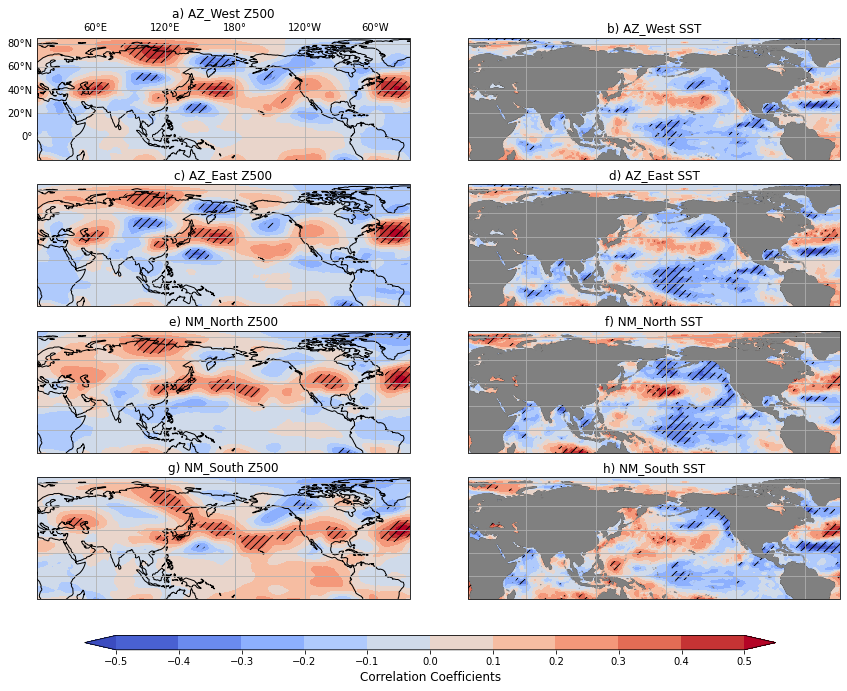

In [7]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']
rgsWTvars = ['Z500','SST']

fig = plt.figure(figsize=(12,10))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(4,2)
gs1.update(left=0.03, right=0.99,
   bottom=0.15, top=0.93,
   wspace=0.08, hspace=0.2)

for va in range(len(ERA_Var)):
    for re in range(WTsFIN.shape[1]):

        proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
        ax = plt.subplot(gs1[re,va], projection=proj)
        pos1 = ax.get_position()
        cs = plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,re,va,0], levels=np.linspace(-0.5,0.5,11), transform=ccrs.PlateCarree(),
                          extend='both', cmap='coolwarm')#, cmap='hot_r')
    #         plt.title(rgsLableABC[se+st*4]+') '+season+' '+Label)
        plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,re,va,1]<=0.1 , levels=[0,0.9,1.1] ,
                     transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)


        ax.coastlines()
        ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree())
        if (re == 0) & (va == 0):
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.right_labels = False
            gl.bottom_labels = False
        else:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False

        plt.title(rgsLableABC[va+re*2]+') '+REGIONS[re]+' '+rgsWTvars[va])
        
        if va == 1:
            import cartopy
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'))
            
CbarAx = axes([0.1, 0.08, 0.8, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-0.5,0.5,11))
cb.set_label('Correlation Coefficients', fontsize=12)

sPlotFile=''
sPlotName= 'ZG500-SST_monsoon-WT_correlation.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

100%|██████████| 241/241 [00:32<00:00,  7.49it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
100%|██████████| 241/241 [00:41<00:00,  5.80it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 241/241 [00:36<00:00,  6.52it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in less_equal
100%|██████████| 241/241 [00:38<00:00,  6.31it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: The 'extend' parameter to Col

        Plot map to: ZG500-SST_monsoon-WT_coefficient-of-variation.pdf


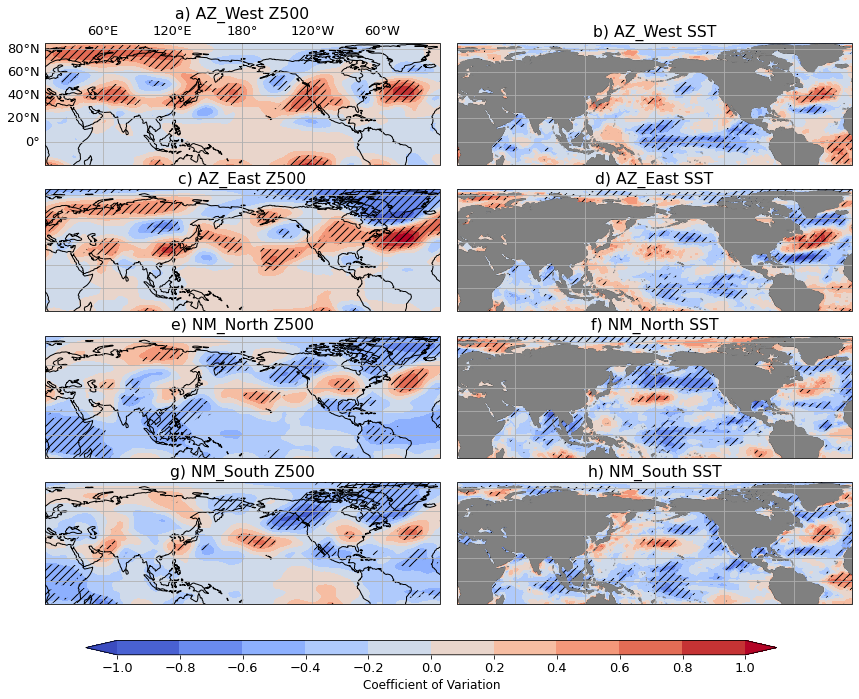

In [62]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']
rgsWTvars = ['Z500','SST']
TopYYYY = 0.25 # percentile

fig = plt.figure(figsize=(12,10))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(4,2)
gs1.update(left=0.05, right=0.99,
   bottom=0.15, top=0.93,
   wspace=0.03, hspace=0.2)

for va in range(len(ERA_Var)):
    for re in range(WTsFIN.shape[1]):

        proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
        ax = plt.subplot(gs1[re,va], projection=proj)
        pos1 = ax.get_position()
        
        WTs = MonsoonWT_Ytotal[:,re]
        DATA = np.copy(Z500_Ymean[:,:,:,va])
        TOP = int(np.round(Z500_Ymean.shape[0]*TopYYYY, 0))
        PEAK = np.argsort(WTs)[-TOP:]
        NonPeak = np.argsort(WTs)[:-TOP]
        ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)

        SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
        for la in tqdm(range(DATA.shape[1])):
            for lo in range(DATA.shape[2]):
                try:
                    testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
                except:
                    continue

        cs = plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                          extend='both', cmap='coolwarm')
        plt.contourf(rgrLonWT,rgrLatWT, SIG[:,:]<=0.1 , levels=[0,0.9,1.1] ,
                 transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)


        ax.coastlines()
        ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
        if (re == 0) & (va == 0):
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.right_labels = False
            gl.bottom_labels = False
        else:
            gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
            gl.top_labels = gl.right_labels = gl.left_labels = gl.bottom_labels = False

        plt.title(rgsLableABC[va+re*2]+') '+REGIONS[re]+' '+rgsWTvars[va])
        
        if va == 1:
            import cartopy
            import cartopy.crs as ccrs
            import cartopy.feature as cfeature
            ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'))
            
CbarAx = axes([0.1, 0.08, 0.8, 0.02])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-1,1,11))
cb.set_label('Coefficient of Variation', fontsize=12)

sPlotFile=''
sPlotName= 'ZG500-SST_monsoon-WT_coefficient-of-variation.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)

### READ NMME DATA

In [8]:
########################################
#                            USER INPUT SECTION


NMME_dir = '/glade/collections/cdg/data/nmme/output1/'
IFS_dir = '/glade/campaign/mmm/c3we/ECMWF/'
# center/model name, ensemble members, file convention
NMME_models = [['NCAR/CESM1',10,'day_CESM1'], #['CCCMA','NASA-GMAO','NCAR/CESM1', 'NCEP','NOAA-GFDL','UM-RSMAS']
               ['NASA-GMAO/GEOS-5',10,'day_GEOS-5'], # maskes out below surface areas --> use 650 hPa level
               ['UM-RSMAS/CCSM4', 10, 'day_CCSM4'],
               ['CCCMA/CanCM4', 10, 'day_CanCM4'],  # only has 675 hPa data
               ['IFS', 25, 'day_CanCM4']] # only 7 month forecast but 25 members
ConstantFile = [NMME_dir+'NCAR/CESM1/19820101/day/atmos/hus/hus_day_CESM1_19820101_r4i1p1_19820100-19821231.nc4',
               NMME_dir+'NASA-GMAO/GEOS-5/19820101/day/atmos/hus/hus_day_GEOS-5_19820101_r1i1p1.nc',
               NMME_dir+'UM-RSMAS/CCSM4/20050801/day/atmos/hus/hus_day_CCSM4_20050801_r10i1p1_20050801-20060731.nc',
               NMME_dir+'CCCMA/CanCM4/19840101/day/atmos/v20181101/hus/hus_day_CanCM4_198401_r10i1p1_19840101-19841231.nc4',
               IFS_dir+'20050601/Q_GDS0_ISBL/Q_GDS0_ISBL_day_ECMWF_mem01_20050601.nc']
DataDir = [NMME_dir,
          NMME_dir,
          NMME_dir,
          NMME_dir,
          IFS_dir]

# for each variable we have the general varname, the netCDF var name, and the pressure level (-1 means 2D field), netCDF varname
ImputVars=[[['Z500','g',1,'G']],
            [['Z500','g',16,'g']], # level 13 is 650hPa; 850 hPa is level 6
            [['Z500','g',1,'G']],
            [['Z500','g',1,'g']],
            [['Z500','Q_GDS0_ISBL',-1,'Q_GDS0_ISBL_daily']]]

SaveDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/'

MONTHS=[6,7] #,8,9,10] # [1,2,3,4,5,6,7,8,9,10,11,12]
StartMonths=[4,6] #[2,3,4,5,6,7,8]

dStartDay=datetime.datetime(int(1982), 1, 1,12)
dStopDay=datetime.datetime(int(2010), 12, 31,12)


rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
rgdTimeMM = pd.date_range(dStartDay, end=dStopDay, freq='m')
rgiYY=np.unique(rgdTimeDD.year)
rgdTimeDD = rgdTimeDD[np.isin(rgdTimeDD.month, MONTHS)]
rgdTimeMM = rgdTimeMM[np.isin(rgdTimeMM.month, MONTHS)]



In [9]:
WTlon = np.copy(rgrLonWT[2:-2,2:-2])
WTlon[WTlon< 0] = WTlon[WTlon< 0]+360
WTlat = rgrLatWT[2:-2,2:-2]

In [10]:
from dateutil.relativedelta import relativedelta
from datetime import timedelta
from calendar import monthrange

# NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),rgrLonT.shape[0],rgrLonT.shape[1],len(ImputVars[mo]), NMME_models[mo][1])); NMMEdata[:] = np.nan

iModels = range(4)
mo=0

SAVE_NMME = sDataDir+'NMME_ZG_daily_June-July.npz'
if os.path.isfile(SAVE_NMME) == False:
    NMMEdata = np.zeros((sum(rgdTimeDD.year == rgiYY[0]), len(rgiYY), len(StartMonths),WTlon.shape[0],WTlat.shape[1],len(ImputVars[mo]), NMME_models[mo][1], len(iModels))); NMMEdata[:] = np.nan


    for mo in range(len(iModels)):
        # ________________________________________________________________________
        # read ERA-Interim & NMME Grid
        sERAconstantFields='/glade/work/prein/reanalyses/ERA-Interim/ERA_Inerim_stationary-files_75x75.nc'
        # read the ERA-Interim elevation
        ncid=Dataset(sERAconstantFields, mode='r')
        rgrLat75=np.squeeze(ncid.variables['latitude'][:])
        rgrLon75=np.squeeze(ncid.variables['longitude'][:])
        rgrHeight=(np.squeeze(ncid.variables['z'][:]))/9.81
        rgrLSM=(np.squeeze(ncid.variables['lsm'][:]))
        ncid.close()
        rgdTimeDD_Full = pd.date_range(datetime.datetime(int(1979), 1, 1,12), end=datetime.datetime(int(2017), 12, 31,12), freq='d')
    #     rgrLonT = rgrLon75
    #     rgrLatT = rgrLat75

        # read NMME coordinates
        ncid=Dataset(ConstantFile[mo], mode='r')
        if 'lon' in list(ncid.variables.keys()):
            rgrLonS=np.squeeze(ncid.variables['lon'][:])
            rgrLatS=np.squeeze(ncid.variables['lat'][:])
        elif 'LON' in list(ncid.variables.keys()):
            rgrLonS=np.squeeze(ncid.variables['LON'][:])
            rgrLatS=np.squeeze(ncid.variables['LAT'][:])
        elif 'g0_lon_4' in list(ncid.variables.keys()):
            rgrLonS=np.squeeze(ncid.variables['g0_lon_4'][:])
            rgrLatS=np.squeeze(ncid.variables['g0_lat_3'][:])

        ncid.close()
        rgrLonSF, rgrLatSF = np.meshgrid(rgrLonS, rgrLatS)
    #     rgrLonSF[rgrLonSF>180] = rgrLonSF[rgrLonSF>180]-360
        rgrLonSF[rgrLonSF<0] = rgrLonSF[rgrLonSF<0]+360

        if NMME_models[mo][0] == 'IFS':
            rgrLatSF = rgrLatSF[::-1] # IFS lat runs from N to S

        # get the region of interest
        iAddCells= 0 # grid cells added to subregion
        # iWest=np.argmin(np.abs(rgrLonT.min() - rgrLonSF[0,:]))-iAddCells
        # iEast=np.argmin(np.abs(rgrLonT.max() - rgrLonSF[0,:]))+iAddCells
        # iNort=np.argmin(np.abs(rgrLatT.max() - rgrLatSF[:,0]))+iAddCells
        # iSouth=np.argmin(np.abs(rgrLatT.min() - rgrLatSF[:,0]))-iAddCells

        iWest=1 #np.argmin(np.abs(WTlon.min() - rgrLonSF[0,:]))-iAddCells
        iEast=rgrLonSF.shape[1]-1 #np.argmin(np.abs(WTlon.max() - rgrLonSF[0,:]))+iAddCells
        iNort=rgrLonSF.shape[0]-1 #np.argmin(np.abs(WTlat.max() - rgrLatSF[:,0]))+iAddCells
        iSouth=1 #np.argmin(np.abs(WTlat.min() - rgrLatSF[:,0]))-iAddCells

        rgrLonS=rgrLonSF[iSouth:iNort,iWest:iEast]
        rgrLatS=rgrLatSF[iSouth:iNort,iWest:iEast]

        # create gregridding weights
        # Remap Gridsat to ERA5
        points=np.array([rgrLonS.flatten(), rgrLatS.flatten()]).transpose()
        # vtx, wts = interp_weights(points, np.append(rgrLonT.flatten()[:,None], rgrLatT.flatten()[:,None], axis=1))
        vtx, wts = interp_weights(points, np.append(WTlon.flatten()[:,None], WTlat.flatten()[:,None], axis=1))


        for yy in tqdm(range(len(rgiYY))):
    #         print('    process '+str(rgiYY[yy]))
            DD_monsoonseason = pd.date_range(datetime.datetime(rgiYY[yy], MONTHS[0], 1,0), end=datetime.datetime(rgiYY[yy], MONTHS[-1], monthrange(rgiYY[yy], MONTHS[-1])[1],0), freq='d')
            for mm in range(len(StartMonths)):
    #             print('        month '+str(StartMonths[mm]))
                TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)+'01'
                dStartACT=datetime.datetime(rgiYY[yy], StartMonths[mm], 1,0)
                if NMME_models[mo][0] in ['NCAR/CESM1','UM-RSMAS/CCSM4','CCCMA/CanCM4']:
                    dStopACT = dStartACT + relativedelta(months=+12) - timedelta(days=1)
                    rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
                elif NMME_models[mo][0] == 'IFS':
                    dStopACT = dStartACT + relativedelta(days=+214)
                    rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
                else:
                    dStopACT = dStartACT + relativedelta(months=+9) - timedelta(days=1)
                    rgdTimeACT = pd.date_range(dStartACT, end=dStopACT, freq='d')
                for va in range(len(ImputVars[mo])):
                    if NMME_models[mo][0] == 'CCCMA/CanCM4':
                        DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/v20181101/'+ImputVars[mo][va][1]+'/'
                    elif NMME_models[mo][0] == 'IFS':
                        if (rgiYY[yy] >= 1993) & (StartMonths[mm] >= 4):
                            DirNameAct = DataDir[mo]+'/'+TIMEstamp+'/'+ImputVars[mo][va][1]+'/'
                        else:
                            continue
                    else:
                        DirNameAct = DataDir[mo]+NMME_models[mo][0]+'/'+TIMEstamp+'/day/atmos/'+ImputVars[mo][va][1]+'/'

                    for en in range(NMME_models[mo][1]):
                        YYYYMMDD_start = str(rgdTimeACT[0].year)+str(rgdTimeACT[0].month).zfill(2)+'00' #str(rgdTimeACT[0].day).zfill(2)
                        YYYYMMDD_stop = str(rgdTimeACT[-1].year)+str(rgdTimeACT[-1].month).zfill(2)+'*' #str(rgdTimeACT[-1].day).zfill(2)
                        if NMME_models[mo][0] == 'CCCMA/CanCM4':
                            TIMEstamp = str(rgiYY[yy])+str(StartMonths[mm]).zfill(2)
                        if NMME_models[mo][0] != 'IFS':
                            try:
                                FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')[0]
                            except:
                                print('            Data missing: '+DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1*'+'.nc*')
                                continue
                        else:
                            try:
                                FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_day_ECMWF_mem'+str(en+1).zfill(2)+'*.nc')[0]
                            except:
                                continue
        #                 FileName = glob.glob(DirNameAct+ImputVars[mo][va][1]+'_'+NMME_models[mo][2]+'_'+TIMEstamp+'_r'+str(en+1)+'i1p1_'+YYYYMMDD_start+'-'+YYYYMMDD_stop+'.nc*')[0]
                        iTime = np.isin(rgdTimeACT.month, MONTHS) & np.isin(rgdTimeACT.year, rgiYY[yy])
                        # read the data
                        ncid=Dataset(FileName, mode='r')
                        if ImputVars[mo][va][2] == -1:
                            # data has no level dimension (is 3D)
                            DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,:,:])[:,::-1,:][:,iSouth:iNort,iWest:iEast]
                        else:
                            try:
                                DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime,ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                            except:
                                # some models do not have leap years
                                DATAact=np.squeeze(ncid.variables[ImputVars[mo][va][3]][iTime[:-1],ImputVars[mo][va][2],iSouth:iNort,iWest:iEast])
                        ncid.close()
                        try:
                            T0 = np.where(rgdTimeACT[0] == DD_monsoonseason)[0][0]
                        except:
                            T0 = 0
                        # Remap the data to the target (centroid) grid
                        for tt in range(sum(iTime)):
                            valuesi=interpolate(DATAact[tt,:,:].flatten(), vtx, wts)
    #                         NMMEdata[T0+tt,yy,mm,:,:,va,en] = valuesi.reshape(rgrLonT.shape[0],rgrLonT.shape[1])
                            NMMEdata[T0+tt,yy,mm,:,:,va,en,mo] = valuesi.reshape(WTlon.shape[0],WTlat.shape[1])
    MEAN_NMME = np.squeeze(np.mean(NMMEdata, axis=(0,6)))
    np.savez(SAVE_NMME,
            MEAN_NMME=MEAN_NMME,
            WTlon=WTlon,
            WTlat=WTlat,
            rgiYY=rgiYY)
else:
    DATA = np.load(SAVE_NMME)
    MEAN_NMME = DATA['MEAN_NMME']
    WTlon = DATA['WTlon']
    WTlat = DATA['WTlat']
    rgiYY = DATA['rgiYY']
    
    


In [11]:
np.savez(sDataDir+'NMME_ZG_daily_June-July.npz',
        MEAN_NMME=MEAN_NMME,
        WTlon=WTlon,
        WTlat=WTlat,
        rgiYY=rgiYY)

### Load the preprocessed NMME WT frequencies

In [12]:
DataDir='/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/'
SRegionsAll = ['1501', '1502', 'HUC6-00', 'HUC6-03']
SRegionNames = ['AZ-West', 'AZ-East', 'NM-North', 'NM-South']
PRfile_basin = ['/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_1501_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_1502_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_HUC6-00_1982-2018_6-7-8-9-10.npz',
               '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/HandK/Precipitation-Records_13514_HUC6-03_1982-2018_6-7-8-9-10.npz']
sPlotFile = '/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/plots/NMME_Hindcasts/'
# center/model name, ensemble members, file convention
NMME_models = ['NCAR-CESM1','NASA-GMAO-GEOS-5','UM-RSMAS-CCSM4','CCCMA-CanCM4','IFS']
ModelColors = ['#1f78b4','#e31a1c','#ff7f00','#33a02c','#fb9a99']

# for each variable we have the general varname, the netCDF var name, and the pressure level (-1 means 2D field), netCDF varname
rgsWTvars = ['Q850']
WTVars=('-').join(rgsWTvars)

MONTHS=[6,7,8,9,10]
StartMonths=[2,3,4,5,6,7,8]
rgsStartMonths=['Feb','Mar','Apr','May','Jun','Jul','Aug']
WTsort = [[0,2,1],[1,2,0],[1,2,0],[0,1,2]]

dStartDay=datetime.datetime(int(1982), 1, 1,0)
dStopDay=datetime.datetime(int(2010), 12, 31,0)
rgdTimeDD = pd.date_range(dStartDay, end=dStopDay, freq='d')
rgdTimeMM = pd.date_range(dStartDay, end=dStopDay, freq='m')
rgiYY=np.unique(rgdTimeDD.year)
rgdTimeDD = rgdTimeDD[np.isin(rgdTimeDD.month, MONTHS)]
rgdTimeMM = rgdTimeMM[np.isin(rgdTimeMM.month, MONTHS)]

YYYY_ERA = np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/NCAR-CESM1_Q850_1982-2010_NM-North_ForecastMonths-2-3-4-5-6_MonsoonMonths-6-7-8-9-10.npz')['YYYY_ERA']
ERA_selYears = np.isin(YYYY_ERA, rgiYY)
TimeMonsSeason = pd.to_datetime(np.load('/glade/campaign/mmm/c3we/prein/Projects/Arizona_WTing/data/NMME/NCAR-CESM1_Q850_1982-2010_NM-North_ForecastMonths-2-3-4-5-6_MonsoonMonths-6-7-8-9-10.npz')['TimeMonsSeason'])


PredMonths = '-'.join(np.array(MONTHS).astype('str'))
sStartMonths = '-'.join(np.array(StartMonths).astype('str'))

ERA_WTs = np.zeros((len(TimeMonsSeason), len(rgiYY), len(StartMonths), len(SRegionNames))); ERA_WTs[:] = np.nan
NAAM_WTs = np.zeros((len(TimeMonsSeason), len(rgiYY), len(NMME_models), len(SRegionNames), len(StartMonths), 25)); NAAM_WTs[:] = np.nan
EAR_Predictors = np.zeros((len(rgiYY),len(TimeMonsSeason), len(StartMonths), len(SRegionNames), len(rgsWTvars))); EAR_Predictors[:] = np.nan
NAAM_Predictors = np.zeros((len(rgiYY),len(TimeMonsSeason), len(StartMonths), len(SRegionNames), len(StartMonths), len(rgsWTvars), 25)); NAAM_Predictors[:] = np.nan
for mo in range(len(NMME_models)):
    for re in range(len(SRegionNames)):
        if NMME_models[mo] != 'IFS':
            DATAfile = DataDir+NMME_models[mo]+'_'+WTVars+'_'+str(rgiYY[0])+'-'+str(rgiYY[-1])+'_'+SRegionNames[re]+'_ForecastMonths-'+sStartMonths+'_MonsoonMonths-'+PredMonths+'.npz'
            DATA = np.load(DATAfile)
            ERA_WTs[:,:,mo,re] = DATA['ERA_WTfin'][ERA_selYears,:].T
            EAR_Predictors[:,:,mo,re] = np.mean(DATA['ERA_predictors'][ERA_selYears,:], axis=(2,3))
            # --
            NAAM_WTs[:,:,mo,re,:,:10] = DATA['WT_NMME']
            NAAM_Predictors[:,:,mo,re,:][:,:,:,:,:10] = np.moveaxis(np.mean(DATA['NMMEpredictors'], axis=(3,4)), 1,0)
        else:
            try:
                DATAfile = DataDir+NMME_models[mo]+'_'+WTVars+'_1982-'+str(rgiYY[-1])+'_'+SRegionNames[re]+'_ForecastMonths-2-3-4-5-6-7-8_MonsoonMonths-'+PredMonths+'.npz'
                DATA = np.load(DATAfile)
                Y_IFS = np.isin(rgiYY,DATA['YYYYY_NMME'])
                M_IFS = np.isin(StartMonths,DATA['StartMonths'])
                ERA_WTs[:,:,mo,re] = DATA['ERA_WTfin'][ERA_selYears,:].T
                NAAM_WTs[:,Y_IFS,mo,re,-np.sum(M_IFS):,:] = DATA['WT_NMME']
                NAAM_Predictors[Y_IFS,:,mo,re,-np.sum(M_IFS):,:,:] = np.moveaxis(np.mean(DATA['NMMEpredictors'], axis=(3,4)), 1,0)
            except:
                print('    Not found: '+DATAfile)

In [13]:
# get the WTs for the same time period
DD_foc = np.isin(rgdTimeDD[rgdTimeDD.year == 1993].month, [6,7])
YY_foc = np.isin(rgiYY, range(1982,2011))
StartMonths=[2,3,4,5,6,7,8]
FCmon_foc = np.isin(StartMonths, [4,6])
NMME_WT_sel = np.copy(NAAM_WTs[DD_foc,:,:,:,:,:][:,YY_foc,:,:,:,:][:,:,:,:,FCmon_foc,:])
MonsoonWT_mod = np.nanmean((NMME_WT_sel == 0), axis=(0,5))

In [14]:
# calcualte correlation coefficients
MOD_correlation = np.zeros((MEAN_NMME.shape[2],MEAN_NMME.shape[3],4,2,MonsoonWT_mod.shape[1], 2))

# DT_MonsoonWT_mod = scipy.signal.detrend(MonsoonWT_mod, axis=0)
# MEAN_NMME[np.isnan(MEAN_NMME)]=0
# DT_MEAN_NMME = scipy.signal.detrend(MEAN_NMME, axis=0)

for mo in range(4):
    for re in [0]: #range(4):
        for fm in range(2):
            for la in tqdm(range(MEAN_NMME.shape[2])):
                for lo in range(MEAN_NMME.shape[3]):
#                     MOD_correlation[la,lo,re,fm,mo,:] = scipy.stats.spearmanr(MEAN_NMME[:,fm,la,lo,mo], MonsoonWT_mod[:,mo,re,fm])
                    MOD_correlation[la,lo,re,fm,mo,:] =  scipy.stats.pearsonr(MEAN_NMME[:,fm,la,lo,mo], MonsoonWT_mod[:,mo,re,fm])

100%|██████████| 237/237 [00:08<00:00, 27.14it/s]


### Add ECMWF forecasts

In [15]:
ERA_TimeMM = pd.date_range(datetime.datetime(1993, 1, 15,12), end=datetime.datetime(2017, 1, 15,12), freq='m')

ncid=Dataset('/glade/campaign/mmm/c3we/prein/S2S/ECMWF/monthly/Z500_ECMWF_hidcast_1993-2016.nc', mode='r')
rgrLat75=np.squeeze(ncid.variables['latitude'][:])
rgrLon75=np.squeeze(ncid.variables['longitude'][:])
ERA_data=(np.squeeze(ncid.variables['z'][:]))/9.81
ncid.close()
rgrLon75,rgrLat75 = np.meshgrid(rgrLon75,rgrLat75)

In [16]:
# cut out the correct data
MM_Apr = np.isin(ERA_TimeMM.month, [4]) # np.isin(ERA_TimeMM.year, rgiYY) & 
MM_Jun = np.isin(ERA_TimeMM.month, [6]) # np.isin(ERA_TimeMM.year, rgiYY) & 
JuneDat = np.mean(np.copy(ERA_data[MM_Jun,:2,:]), axis=(1,2))
AprilDat = np.mean(np.copy(ERA_data[MM_Apr,2:4,:]), axis=(1,2))

ECMWF_JJ = np.append(AprilDat[:,None,:],JuneDat[:,None,:], axis=1)

In [17]:
# load the preprocesse WTs
# this data comes from - projects/Arizona_WTing/programs/NMME_WTing/NMME_WTing.ipynb
DATA = np.load('/glade/u/home/prein/projects/Arizona_WTing/programs/NMME_WTing/ECMWF_mon-WTs.npz')
ECMWF_WTs = DATA['WTs']
ECMWF_YYYY = DATA['rgiYY']
Y_sel = (ECMWF_YYYY < 2017)
WTsEfin = np.mean(ECMWF_WTs[:2,:,:,:,:][:,Y_sel,:,:][:,:,0,[3,5],:], axis=(0,3))
# WTsEfin = np.mean(ECMWF_WTs[:2,:,:,:,:][:,Y_sel,:,:][:,:,0,[3,5],0], axis=(0))

In [18]:
ECMWF_correlation = np.zeros((ECMWF_JJ.shape[2], ECMWF_JJ.shape[3], 4,2,2))
for re in [0]: #range(4):
    for fm in range(2):
        for la in tqdm(range(ECMWF_JJ.shape[2])):
            for lo in range(ECMWF_JJ.shape[3]):
                ECMWF_correlation[la,lo,re,fm,:] = scipy.stats.spearmanr(ECMWF_JJ[:,fm,la,lo], WTsEfin[:,fm])
#                 ECMWF_correlation[la,lo,re,fm,:] = scipy.stats.pearsonr(ECMWF_JJ[:,fm,la,lo], WTsEfin[:,fm])

100%|██████████| 181/181 [00:36<00:00,  5.00it/s]


### Overview maps of teleconections

/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.


        Plot map to: NMME_ZG500-monsoon-WT_correlation.pdf


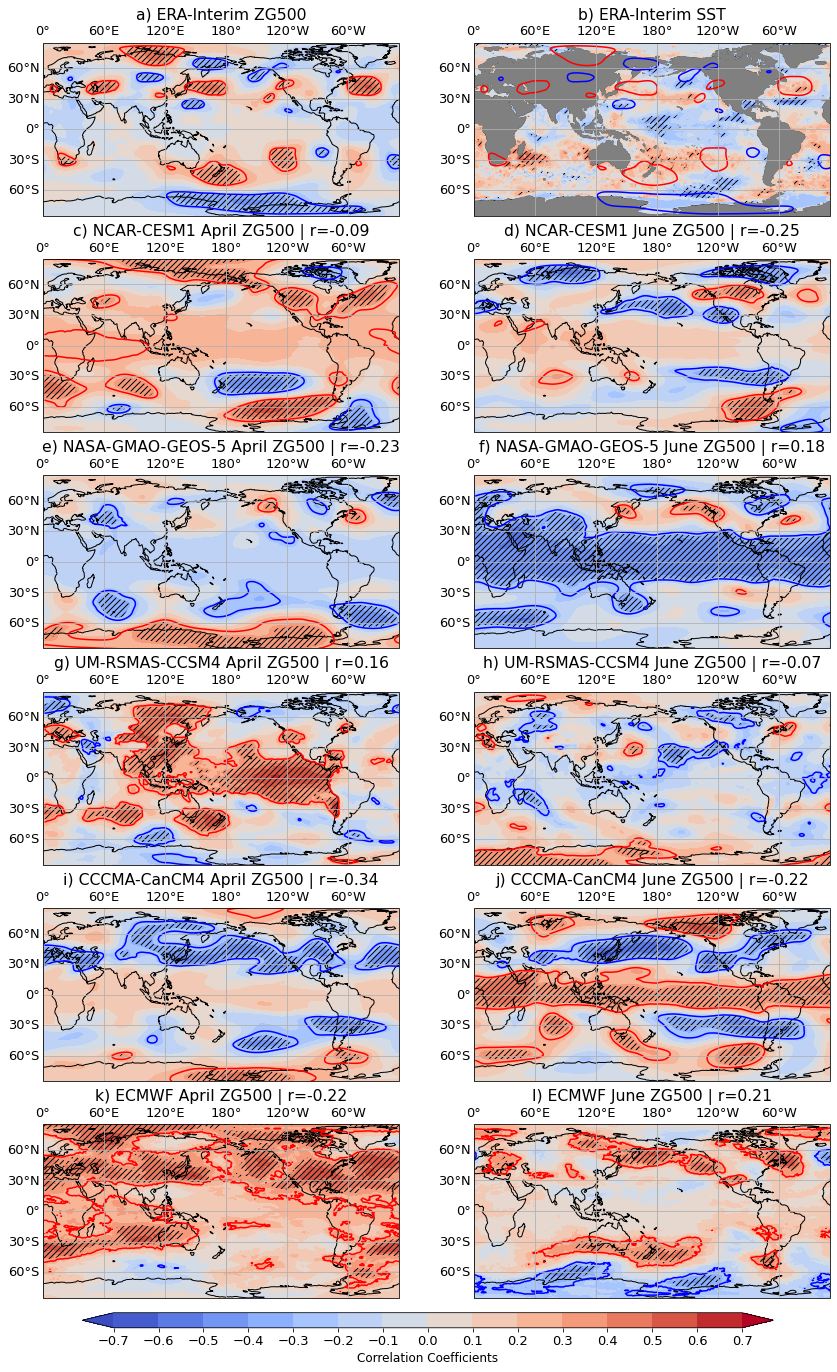

In [19]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm


ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']

plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(12,21))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(6,2)
gs1.update(left=0.03, right=0.99,
   bottom=0.10, top=0.93,
   wspace=0.08, hspace=0.25)
re = 0

# --------------------
# plot ERA-Interim results
proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
VARS = ['ZG500','SST']
FCM = ['April','June']
for va in range(2):
    ax = plt.subplot(gs1[0,va], projection=proj)
    cs = plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,re,va,0], levels=np.linspace(-0.7,0.7,15), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLonWT,rgrLatWT, Correl[:,:,re,va,1]<=0.1 , levels=[0,0.9,1.1] ,
                 transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","////"],alpha=0.)
    plt.contour(rgrLonWT,rgrLatWT, Correl[:,:,re,0,0], levels=[-0.25,0.25], transform=ccrs.PlateCarree(),colors=['b','r'])
    ax.coastlines()
#     ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree())
    ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False

    plt.title(rgsLableABC[va]+') ERA-Interim '+VARS[va])

    if va == 1:
        import cartopy
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'))
            
CbarAx = axes([0.1, 0.08, 0.8, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-0.7,0.7,15))
cb.set_label('Correlation Coefficients', fontsize=12)


# --------------------
# plot NMME results
for mo in range(4):
    for fm in range(2):
        ax = plt.subplot(gs1[1+mo,fm], projection=proj)
        cs = plt.contourf(WTlon,WTlat, MOD_correlation[:,:,re,fm,mo,0], levels=np.linspace(-0.7,0.7,15), transform=ccrs.PlateCarree(),
                          extend='both', cmap='coolwarm')
        plt.contourf(WTlon,WTlat, MOD_correlation[:,:,re,fm,mo,1]<=0.1 , levels=[0,0.9,1.1] ,
                     transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","////"],alpha=0.)
        ax.coastlines()
#         ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree())
        ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())
        
        plt.contour(WTlon,WTlat, MOD_correlation[:,:,re,fm,mo,0], levels=[-0.25,0.25], transform=ccrs.PlateCarree(),colors=['b','r'])

        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.bottom_labels = False
        
        # calculate correlations
        if mo == 0:
            points=np.array([WTlon.flatten(), WTlat.flatten()]).transpose()
            vtx, wts = interp_weights(points, np.append(rgrLonWT.flatten()[:,None], rgrLatWT.flatten()[:,None], axis=1))
        valuesi = interpolate(MOD_correlation[:,:,re,fm,mo,0].flatten(), vtx, wts)
        REMAP = valuesi.reshape(rgrLonWT.shape[0],rgrLonWT.shape[1])
        CORR = scipy.stats.pearsonr(REMAP[2:-2,2:-2].flatten(), Correl[2:-2,2:-2,re,0,0].flatten())[0]
        
        plt.title(rgsLableABC[2+mo*2+fm]+') '+NMME_models[mo]+' '+FCM[fm]+' ZG500 | r='+str(np.round(CORR,2)))
        
# ECMWF
mo = 4
for fm in range(2):
    ax = plt.subplot(gs1[1+mo,fm], projection=proj)
    cs = plt.contourf(rgrLon75,rgrLat75, ECMWF_correlation[:,:,re,fm,0], levels=np.linspace(-0.7,0.7,15), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLon75,rgrLat75, ECMWF_correlation[:,:,re,fm,1]<=0.1 , levels=[0,0.9,1.1] ,
                 transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","////"],alpha=0.)
    plt.contour(rgrLon75,rgrLat75, ECMWF_correlation[:,:,re,fm,0], levels=[-0.25,0.25], transform=ccrs.PlateCarree(), colors=['b','r'])
    ax.coastlines()
#     ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree())
    ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    plt.title(rgsLableABC[2+mo*2+fm]+') ECMWF '+FCM[fm]+' ZG500 | r='+str(np.round(CORR,2)))
    
    # calculate correlations
    if fm == 0:
        points=np.array([rgrLon75.flatten(), rgrLat75.flatten()]).transpose()
        vtx, wts = interp_weights(points, np.append(rgrLonWT.flatten()[:,None], rgrLatWT.flatten()[:,None], axis=1))
    valuesi = interpolate(ECMWF_correlation[:,:,re,fm,0].flatten(), vtx, wts)
    REMAP = valuesi.reshape(rgrLonWT.shape[0],rgrLonWT.shape[1])
    CORR = scipy.stats.pearsonr(REMAP[2:-2,2:-2].flatten(), Correl[2:-2,2:-2,re,0,0].flatten())[0]

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False
        
        
sPlotFile=''
sPlotName= 'NMME_ZG500-monsoon-WT_correlation.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)


### Plot coefficient of variation of annomalies frequent monsoon days

100%|██████████| 241/241 [00:46<00:00,  5.15it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 241/241 [00:42<00:00,  5.69it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less_equal
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be

        Plot map to: NMME_ZG500-monsoon-WT_coefficient-of-variation.pdf


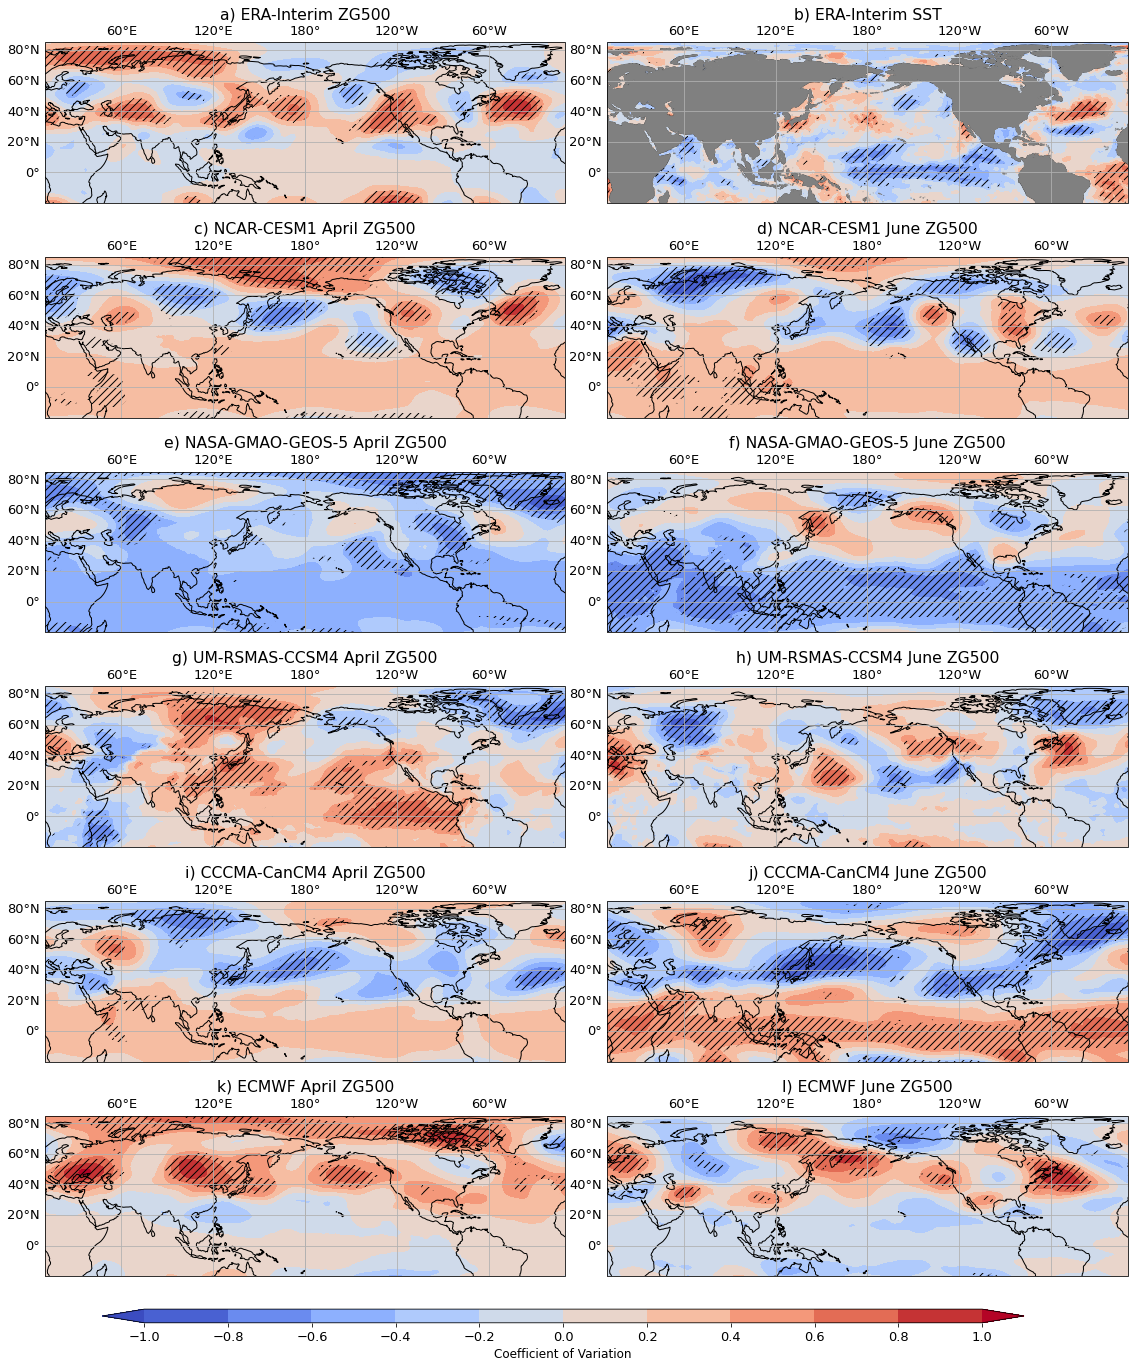

In [65]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

TopYYYY = 0.25 # percentile

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']

plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(16,19))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(6,2)
gs1.update(left=0.05, right=0.99,
   bottom=0.06, top=0.97,
   wspace=0.08, hspace=0.25)
re = 0

# --------------------
# plot ERA-Interim results
proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
VARS = ['ZG500','SST']
FCM = ['April','June']
for va in range(2):
    ax = plt.subplot(gs1[0,va], projection=proj)
    
    WTs = MonsoonWT_Ytotal[:,re]
    DATA = np.copy(Z500_Ymean[:,:,:,va])
    TOP = int(np.round(Z500_Ymean.shape[0]*TopYYYY, 0))
    PEAK = np.argsort(WTs)[-TOP:]
    NonPeak = np.argsort(WTs)[:-TOP]
    ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)
    
    SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
    for la in tqdm(range(DATA.shape[1])):
        for lo in range(DATA.shape[2]):
            try:
                testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
            except:
                continue

    cs = plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLonWT,rgrLatWT, SIG[:,:]<=0.1 , levels=[0,0.9,1.1] ,
             transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
#     plt.contour(rgrLonWT,rgrLatWT, ZG_peak, levels=[-0.5,0.5], transform=ccrs.PlateCarree(),colors=['b','r'])
    ax.coastlines()
    ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#     ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False

    plt.title(rgsLableABC[va]+') ERA-Interim '+VARS[va])

    if va == 1:
        import cartopy
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'))
            
CbarAx = axes([0.1, 0.03, 0.8, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-1,1,11))
cb.set_label('Coefficient of Variation', fontsize=12)


# --------------------
# plot NMME results
for mo in range(4):
    for fm in range(2):
        ax = plt.subplot(gs1[1+mo,fm], projection=proj)
        
        WTs = MonsoonWT_mod[:,mo,re,fm]
        DATA = np.copy(MEAN_NMME[:,fm,:,:,mo])
        TOP = int(np.round(MonsoonWT_mod.shape[0]*TopYYYY, 0))
        PEAK = np.argsort(WTs)[-TOP:]
        NonPeak = np.argsort(WTs)[:-TOP]
        ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)
        
        SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
        for la in tqdm(range(DATA.shape[1])):
            for lo in range(DATA.shape[2]):
                try:
                    testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
                except:
                    continue
        
        cs = plt.contourf(WTlon,WTlat, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                          extend='both', cmap='coolwarm')
        plt.contourf(WTlon,WTlat, SIG<=0.1 , levels=[0,0.9,1.1] ,
                     transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
        ax.coastlines()
        ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#         ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())
        
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.bottom_labels = False
                
        plt.title(rgsLableABC[2+mo*2+fm]+') '+NMME_models[mo]+' '+FCM[fm]+' ZG500')
        
# ECMWF
mo = 4
for fm in range(2):
    ax = plt.subplot(gs1[1+mo,fm], projection=proj)
    
    WTs = WTsEfin[:,fm]
    DATA = np.copy(ECMWF_JJ[:,fm,:,:], )
    TOP = int(np.round(ECMWF_JJ.shape[0]*TopYYYY, 0))
    PEAK = np.argsort(WTs)[-TOP:]
    NonPeak = np.argsort(WTs)[:-TOP]
    ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)

    SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
    for la in tqdm(range(DATA.shape[1])):
        for lo in range(DATA.shape[2]):
            try:
                testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
            except:
                continue
    
    cs = plt.contourf(rgrLon75,rgrLat75, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLon75,rgrLat75, SIG<=0.1 , levels=[0,0.9,1.1] ,
                 transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
#     plt.contour(rgrLon75,rgrLat75, ECMWF_correlation[:,:,re,fm,0], levels=[-0.25,0.25], transform=ccrs.PlateCarree(), colors=['b','r'])
    ax.coastlines()
    ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#     ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    plt.title(rgsLableABC[2+mo*2+fm]+') ECMWF '+FCM[fm]+' ZG500')

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False
        
        
sPlotFile=''
sPlotName= 'NMME_ZG500-monsoon-WT_coefficient-of-variation.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)


### Plot coefficient of variation of annomalies infrequent monsoon days

100%|██████████| 241/241 [00:48<00:00,  4.94it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1508: UserWarning: The following kwargs were not used by contour: 'color', 'edgecolor'
  result = matplotlib.axes.Axes.contourf(self, *args, **kwargs)
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
100%|██████████| 241/241 [00:39<00:00,  6.06it/s]
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in less_equal
/glade/u/apps/dav/opt/python/3.7.9/gnu/9.1.0/pkg-library/20201220/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be

        Plot map to: NMME_ZG500-monsoon-WT_coefficient-of-variation_low-Monsoon-frequency.pdf


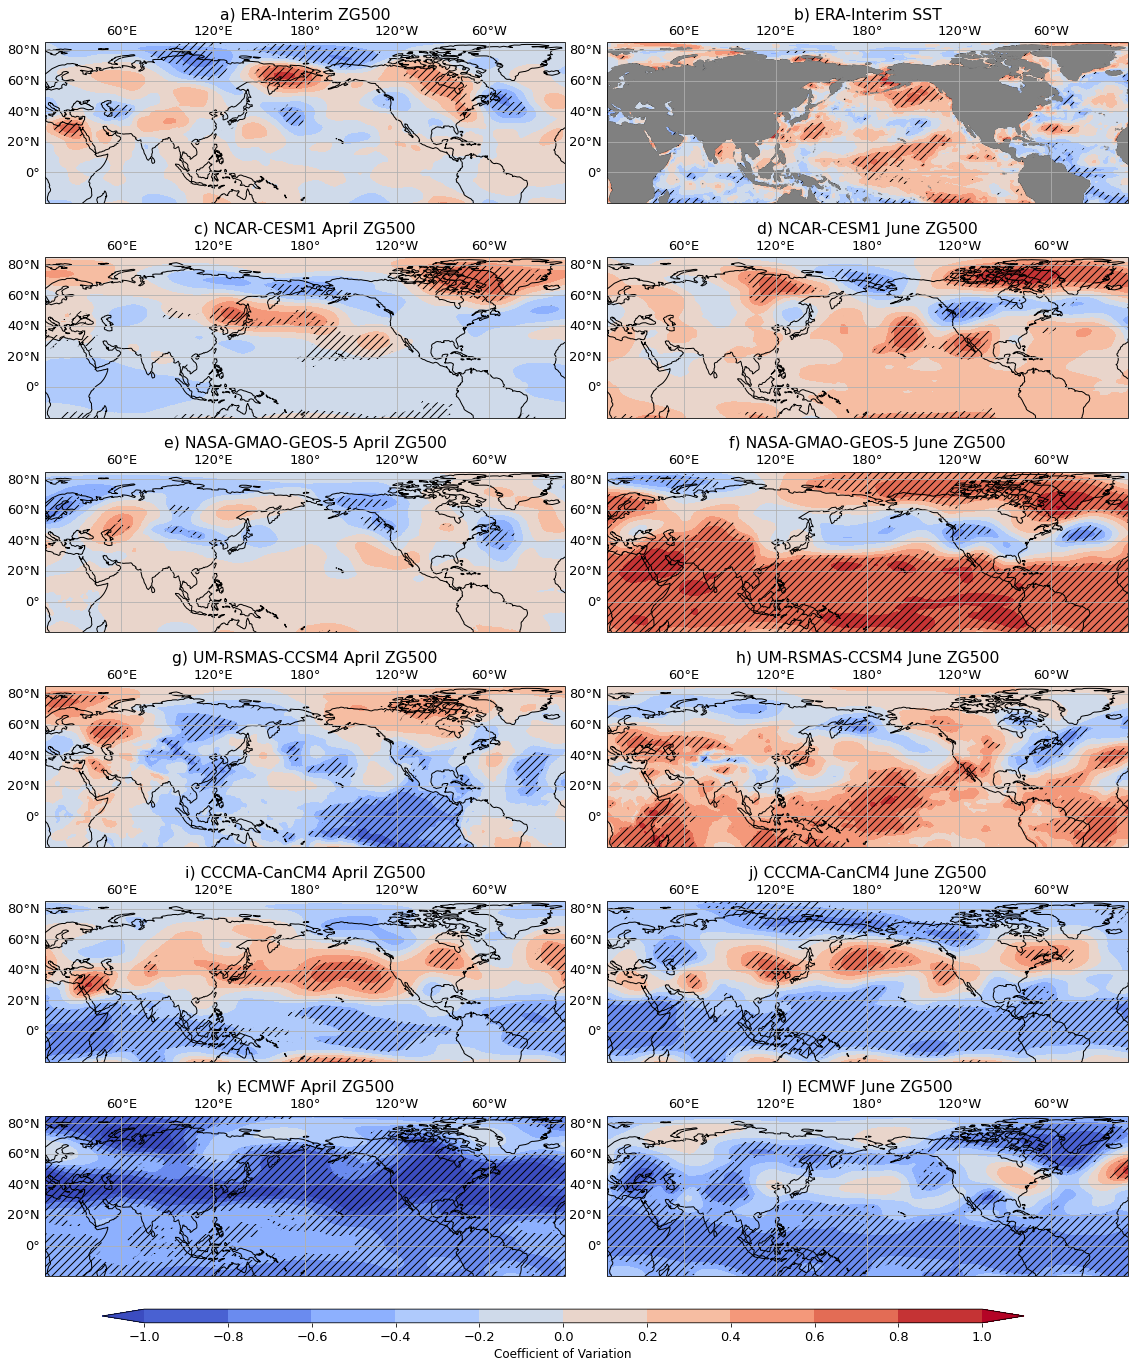

In [68]:
from scipy.ndimage import gaussian_filter
import matplotlib.gridspec as gridspec
# from mpl_toolkits.basemap import Basemap, cm
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec
from pylab import *
import string
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import shapefile

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import shapely.geometry as sgeom
from matplotlib.colors import LogNorm

TopYYYY = 0.25 # percentile

ObjectsSort = ['MCSs','MCS_PR'] 
WTnames = ['dry','normal','monsoon']

plt.rcParams.update({'font.size': 13})
fig = plt.figure(figsize=(16,19))
rgsLableABC=list(string.ascii_lowercase)
gs1 = gridspec.GridSpec(6,2)
gs1.update(left=0.05, right=0.99,
   bottom=0.06, top=0.97,
   wspace=0.08, hspace=0.25)
re = 0

# --------------------
# plot ERA-Interim results
proj = ccrs.PlateCarree(180) #ccrs.Robinson() 
VARS = ['ZG500','SST']
FCM = ['April','June']
for va in range(2):
    ax = plt.subplot(gs1[0,va], projection=proj)
    
    WTs = MonsoonWT_Ytotal[:,re]
    DATA = np.copy(Z500_Ymean[:,:,:,va])
    TOP = int(np.round(Z500_Ymean.shape[0]*TopYYYY, 0))
    PEAK = np.argsort(WTs)[:TOP]
    NonPeak = np.argsort(WTs)[TOP:]
    ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)
    
    SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
    for la in tqdm(range(DATA.shape[1])):
        for lo in range(DATA.shape[2]):
            try:
                testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
            except:
                continue

    cs = plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLonWT,rgrLatWT, SIG[:,:]<=0.1 , levels=[0,0.9,1.1] ,
             transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
#     plt.contour(rgrLonWT,rgrLatWT, ZG_peak, levels=[-0.5,0.5], transform=ccrs.PlateCarree(),colors=['b','r'])
    ax.coastlines()
    ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#     ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False

    plt.title(rgsLableABC[va]+') ERA-Interim '+VARS[va])

    if va == 1:
        import cartopy
        import cartopy.crs as ccrs
        import cartopy.feature as cfeature
        ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m', edgecolor='face', facecolor='gray'))
            
CbarAx = axes([0.1, 0.03, 0.8, 0.01])
cb = colorbar(cs, cax = CbarAx, orientation='horizontal', extend='both', ticks=np.linspace(-1,1,11))
cb.set_label('Coefficient of Variation', fontsize=12)


# --------------------
# plot NMME results
for mo in range(4):
    for fm in range(2):
        ax = plt.subplot(gs1[1+mo,fm], projection=proj)
        
        WTs = MonsoonWT_mod[:,mo,re,fm]
        DATA = np.copy(MEAN_NMME[:,fm,:,:,mo])
        TOP = int(np.round(MonsoonWT_mod.shape[0]*TopYYYY, 0))
        PEAK = np.argsort(WTs)[:TOP]
        NonPeak = np.argsort(WTs)[TOP:]
        ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)
        
        SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
        for la in tqdm(range(DATA.shape[1])):
            for lo in range(DATA.shape[2]):
                try:
                    testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
                except:
                    continue
        
        cs = plt.contourf(WTlon,WTlat, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                          extend='both', cmap='coolwarm')
        plt.contourf(WTlon,WTlat, SIG<=0.1 , levels=[0,0.9,1.1] ,
                     transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
        ax.coastlines()
        ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#         ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())
        
        gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
        gl.right_labels = False
        gl.bottom_labels = False
                
        plt.title(rgsLableABC[2+mo*2+fm]+') '+NMME_models[mo]+' '+FCM[fm]+' ZG500')
        
# ECMWF
mo = 4
for fm in range(2):
    ax = plt.subplot(gs1[1+mo,fm], projection=proj)
    
    WTs = WTsEfin[:,fm]
    DATA = np.copy(ECMWF_JJ[:,fm,:,:], )
    TOP = int(np.round(ECMWF_JJ.shape[0]*TopYYYY, 0))
    PEAK = np.argsort(WTs)[:TOP]
    NonPeak = np.argsort(WTs)[TOP:]
    ZG_peak = (np.mean(DATA[PEAK,:,:], axis=0)-np.mean(DATA[:,:,:], axis=0))/np.std(DATA[:,:,:], axis=0)

    SIG = np.zeros((DATA.shape[1], DATA.shape[2])); SIG[:] = np.nan
    for la in tqdm(range(DATA.shape[1])):
        for lo in range(DATA.shape[2]):
            try:
                testval, SIG[la,lo] = scipy.stats.mannwhitneyu(DATA[PEAK,la,lo], DATA[NonPeak,la,lo])
            except:
                continue
    
    cs = plt.contourf(rgrLon75,rgrLat75, ZG_peak, levels=np.linspace(-1,1,11), transform=ccrs.PlateCarree(),
                      extend='both', cmap='coolwarm')
    plt.contourf(rgrLon75,rgrLat75, SIG<=0.1 , levels=[0,0.9,1.1] ,
                 transform=ccrs.PlateCarree(),color='none',edgecolor='black',hatches=["","///"],alpha=0.)
#     plt.contour(rgrLon75,rgrLat75, ECMWF_correlation[:,:,re,fm,0], levels=[-0.25,0.25], transform=ccrs.PlateCarree(), colors=['b','r'])
    ax.coastlines()
    ax.set_extent((10, 180+170, -20, 85), ccrs.PlateCarree())
#     ax.set_extent((0, 180+170, -85, 85), ccrs.PlateCarree())

    plt.title(rgsLableABC[2+mo*2+fm]+') ECMWF '+FCM[fm]+' ZG500')

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.right_labels = False
    gl.bottom_labels = False
        
        
sPlotFile=''
sPlotName= 'NMME_ZG500-monsoon-WT_coefficient-of-variation_low-Monsoon-frequency.pdf'
if os.path.isdir(sPlotFile) != 1:
    subprocess.call(["mkdir","-p",sPlotFile])
print('        Plot map to: '+sPlotFile+sPlotName)
fig.savefig(sPlotFile+sPlotName)


In [69]:
int(np.round(Z500_Ymean.shape[0]*TopYYYY, 0))

9

37

In [39]:
TopYYYY=0.25

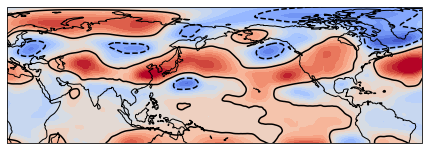

In [21]:
fm=1
PEAK = np.argsort(MonsoonWT_Ytotal[:,0])[-5:]
ZG_peak = (np.mean(Z500_Ymean[PEAK,:,:,0], axis=0)-np.mean(Z500_Ymean[:,:,:,0], axis=0))/np.std(Z500_Ymean[:,:,:,0], axis=0)


gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.03, right=0.99,
   bottom=0.15, top=0.93,
   wspace=0.08, hspace=0.2)

ax = plt.subplot(gs1[0,0], projection=proj)
# plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(-200,200,21), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(-1,1,21), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())

plt.contour(rgrLonWT,rgrLatWT, ZG_peak, levels=[-0.5,0.2], transform=ccrs.PlateCarree(),colors='k')
ax.coastlines()
ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree())

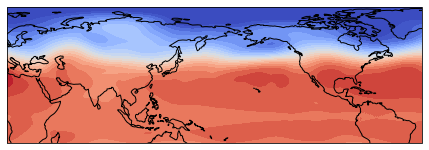

In [22]:
fm=1
PEAK = np.argsort(MonsoonWT_Ytotal[:,0])[-1:]
ZG_peak = np.mean(Z500_Ymean[PEAK,:,:,0], axis=0) #-np.mean(Z500_Ymean[:,:,:,0], axis=0))


gs1 = gridspec.GridSpec(1,1)
gs1.update(left=0.03, right=0.99,
   bottom=0.15, top=0.93,
   wspace=0.08, hspace=0.2)

ax = plt.subplot(gs1[0,0], projection=proj)
plt.contourf(rgrLonWT,rgrLatWT, ZG_peak, levels=np.linspace(54000,58000,21), cmap='coolwarm', extend='both', transform=ccrs.PlateCarree())
# plt.contour(rgrLonWT,rgrLatWT, Correl[:,:,re,va,0], levels=[-0.2,0.2], transform=ccrs.PlateCarree(),colors='k')
ax.coastlines()
ax.set_extent((10, 180+150, -20, 85), ccrs.PlateCarree()) 

In [23]:
MonsoonWT_Ytotal.shape

(37, 4)

In [24]:
re

0